## 1. Подключение библиотек и создание SparkSession

In [2]:
import os
from pyspark import SparkConf
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import *
from pyspark.sql.functions import (
    col, lit, when, expr, trim, upper, lower,
    to_timestamp, regexp_replace, regexp_extract,
    year, month, dayofweek, hour, round as s_round,
    count, countDistinct, avg, stddev, approx_count_distinct
)

In [3]:
conf = (
    SparkConf()
    .setAppName("SOBD_Lab1_Local_Taxi")
    .setMaster("local[*]")               # все ядра
    .set("spark.driver.memory", "8g")
    .set("spark.sql.execution.arrow.pyspark.enabled", "true")
    .set("spark.sql.shuffle.partitions", "200")  
    .set("spark.ui.showConsoleProgress", "true")
)

spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark


## 2. Путь к данным и чтение CSV

In [4]:
path = "/home/jovyan/work/data/2018_Yellow_Taxi_Trip_Data.csv"

df_raw = (
    spark.read.csv(
        path,
        header=True,
        inferSchema=True,
        multiLine=False,
        mode="PERMISSIVE"
    )
)

df_raw.printSchema()
df_raw.show(5, truncate=False)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)

+--------+----------------------+----------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+--------------------

## 3. Привести имена к snake_case и зафиксировать типы

In [5]:
# helper: упрощаем названия столбцов
def to_snake(s: str) -> str:
    return (
        s.strip()
         .replace(" ", "_")
         .replace("-", "_")
         .replace(".", "_")
         .lower()
    )

df = df_raw.toDF(*[to_snake(c) for c in df_raw.columns])

# привести типы (где нужно) и распарсить даты
# если каких-то столбцов в твоём csv нет — просто убери их из списка.
casts = {
    "passenger_count": "int",
    "trip_distance": "double",
    "ratecodeid": "int",
    "pulocationid": "int",
    "dolocationid": "int",
    "payment_type": "int",
    "fare_amount": "double",
    "extra": "double",
    "mta_tax": "double",
    "tip_amount": "double",
    "tolls_amount": "double",
    "improvement_surcharge": "double",
    "total_amount": "double",
    "congestion_surcharge": "double",
}

for c, t in casts.items():
    if c in df.columns:
        df = df.withColumn(c, col(c).cast(t))

# даты-время
for tcol in ["tpep_pickup_datetime", "tpep_dropoff_datetime"]:
    if tcol in df.columns and dict(df.dtypes)[tcol] != "timestamp":
        df = df.withColumn(tcol, to_timestamp(col(tcol)))

df.printSchema()


root
 |-- vendorid: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- ratecodeid: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pulocationid: integer (nullable = true)
 |-- dolocationid: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



## 4. Проверка качества: пропуски/дубликаты

In [22]:
# Проверяем только существование null (isNull), без isnan
missing_df = (
    df.select([
        count(when(col(c).isNull(), c)).alias(c)
        for c in df.columns
    ])
)

missing_df.show(truncate=False)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|ratecodeid|store_and_fwd_flag|pulocationid|dolocationid|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|0       |112234626           |112234626            |0              |19           |0         |0                 |0           |0           |0           |164        |0    |0      |0         |2           |3                    |175         |
+--------+--------------------+-----------------

In [24]:
duplicates_count = df.count() - df.dropDuplicates().count()
print(f"Количество дубликатов: {duplicates_count}")

Количество дубликатов: 53283663


In [25]:
# Общая статистика 
df.describe(
    "trip_distance", "fare_amount", "tip_amount", "total_amount"
).show()

+-------+------------------+------------------+------------------+------------------+
|summary|     trip_distance|       fare_amount|        tip_amount|      total_amount|
+-------+------------------+------------------+------------------+------------------+
|  count|         112234607|         112234462|         112234626|         112234451|
|   mean| 2.927286994999614|12.973791676838161|1.8724737629546295|16.322630659750782|
| stddev|3.7947920734656275|11.608532977517957|2.6079470523617907|14.351499573938906|
|    min|               0.0|            -800.0|           -322.42|            -800.3|
|    max|             943.5|            999.99|            945.97|            999.56|
+-------+------------------+------------------+------------------+------------------+



In [6]:
from pyspark.sql.functions import col, to_timestamp, trim

# 1. стартуем снова от сырого df_raw и делаем snake_case
df = df_raw.toDF(*[c.strip().replace(" ","_").replace("-","_").replace(".","_").lower()
                   for c in df_raw.columns])

# 2. ПРАВИЛЬНЫЙ формат для твоих дат + обрезаем пробелы
fmt = "M/d/yyyy h:mm:ss a"   # напр.: 07/17/2018 10:14:57 AM

df = (
    df.withColumn("tpep_pickup_datetime",
                  to_timestamp(trim(col("tpep_pickup_datetime")), fmt))
      .withColumn("tpep_dropoff_datetime",
                  to_timestamp(trim(col("tpep_dropoff_datetime")), fmt))
)

# проверка
df.select("tpep_pickup_datetime","tpep_dropoff_datetime").show(5, truncate=False)


+--------------------+---------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|
+--------------------+---------------------+
|2018-07-17 10:14:57 |2018-07-17 10:22:45  |
|2018-07-17 10:23:50 |2018-07-17 10:37:49  |
|2018-07-17 10:39:57 |2018-07-17 11:07:52  |
|2018-07-17 10:12:58 |2018-07-17 10:22:47  |
|2018-07-17 10:24:49 |2018-07-17 10:48:37  |
+--------------------+---------------------+
only showing top 5 rows



In [34]:
# Временной диапазон поездок 
from pyspark.sql.functions import min, max


df.select(
    min("tpep_pickup_datetime").alias("min_pickup"),
    max("tpep_dropoff_datetime").alias("max_dropoff")
).show()

+-------------------+-------------------+
|         min_pickup|        max_dropoff|
+-------------------+-------------------+
|2001-01-01 00:01:48|2084-11-04 12:47:41|
+-------------------+-------------------+



In [35]:
from pyspark.sql.functions import col, when


# Добавляем длительность и скорость
df = (
    df.withColumn("trip_minutes", 
        (col("tpep_dropoff_datetime").cast("long") - col("tpep_pickup_datetime").cast("long")) / 60.0
    )
    .withColumn("trip_hours", col("trip_minutes") / 60.0)
    .withColumn("speed_mph", when(col("trip_hours") > 0, col("trip_distance") / col("trip_hours")))
)

df.select("trip_distance", "trip_minutes", "trip_hours", "speed_mph").show(5)


+-------------+------------------+-------------------+------------------+
|trip_distance|      trip_minutes|         trip_hours|         speed_mph|
+-------------+------------------+-------------------+------------------+
|            1|               7.8|               0.13| 7.692307692307692|
|         1.24|13.983333333333333|0.23305555555555554|  5.32061978545888|
|         5.12|27.916666666666668| 0.4652777777777778|11.004179104477611|
|         0.88| 9.816666666666666| 0.1636111111111111| 5.378607809847199|
|         2.07|              23.8|0.39666666666666667| 5.218487394957982|
+-------------+------------------+-------------------+------------------+
only showing top 5 rows



## 5.Выбросы

In [7]:
sample_df = df.select("trip_distance", "fare_amount", "total_amount", "tip_amount").sample(False, 0.001, seed=42)
pandas_df = sample_df.toPandas()

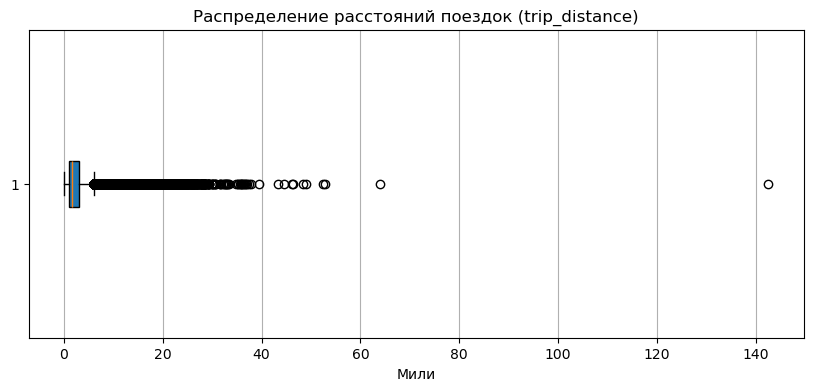

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Приводим числовые колонки к float и убираем NaN
pandas_df["trip_distance"] = pd.to_numeric(pandas_df["trip_distance"], errors="coerce")
pandas_df["fare_amount"] = pd.to_numeric(pandas_df["fare_amount"], errors="coerce")
pandas_df["total_amount"] = pd.to_numeric(pandas_df["total_amount"], errors="coerce")
pandas_df["tip_amount"] = pd.to_numeric(pandas_df["tip_amount"], errors="coerce")

pandas_df = pandas_df.dropna(subset=["trip_distance"])

# График
plt.figure(figsize=(10, 4))
plt.boxplot(pandas_df["trip_distance"], vert=False, patch_artist=True)
plt.title("Распределение расстояний поездок (trip_distance)")
plt.xlabel("Мили")
plt.grid(True, axis='x')
plt.show()

## Фильтрация выбросов

In [9]:
from pyspark.sql.functions import col

df_clean = (
    df.filter((col("trip_distance") > 0.1) & (col("trip_distance") < 100))
      .filter((col("fare_amount") > 0) & (col("fare_amount") < 500))
      .filter((col("total_amount") > 0) & (col("total_amount") < 500))
)

print("✅ Очистка завершена")
print(f"Строк до очистки: {df.count()}")
print(f"Строк после очистки: {df_clean.count()}")


✅ Очистка завершена
Строк до очистки: 112234626
Строк после очистки: 111082315


In [10]:
df_clean.select("trip_distance", "fare_amount", "total_amount").show(10, truncate=False)

+-------------+-----------+------------+
|trip_distance|fare_amount|total_amount|
+-------------+-----------+------------+
|1            |7          |10.14       |
|1.24         |9.5        |11.33       |
|5.12         |22         |24.8        |
|0.88         |7.5        |8.3         |
|2.07         |15         |16.59       |
|1.2          |8.5        |11.15       |
|1.3          |10         |10.8        |
|4.03         |20.5       |25.56       |
|2.31         |16.5       |19.3        |
|0.63         |5          |6.96        |
+-------------+-----------+------------+
only showing top 10 rows



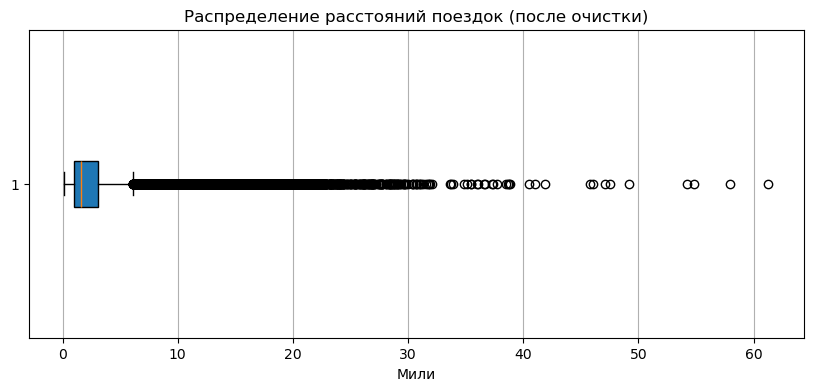

In [12]:
# Выборка из очищенных данных
sample_clean = df_clean.select("trip_distance").sample(False, 0.001, seed=42)
pandas_clean = sample_clean.toPandas()

# Преобразуем к числу (на случай строк)
pandas_clean["trip_distance"] = pd.to_numeric(pandas_clean["trip_distance"], errors="coerce")

# Удаляем NaN
pandas_clean = pandas_clean.dropna(subset=["trip_distance"])

# График boxplot
plt.figure(figsize=(10, 4))
plt.boxplot(pandas_clean["trip_distance"], vert=False, patch_artist=True)
plt.title("Распределение расстояний поездок (после очистки)")
plt.xlabel("Мили")
plt.grid(True, axis='x')
plt.show()

## 6.Сохранение очищенных данных

In [14]:
output_path = "/home/jovyan/work/data/clean_taxi_data.parquet"

df_clean.write.mode("overwrite").parquet(output_path)
print(f"✅ Данные успешно сохранены в {output_path}")

✅ Данные успешно сохранены в /home/jovyan/work/data/clean_taxi_data.parquet


In [15]:
df_check = spark.read.parquet(output_path)
print("Количество строк:", df_check.count())
df_check.show(5)

Количество строк: 111082315
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|ratecodeid|store_and_fwd_flag|pulocationid|dolocationid|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       2| 2018-12-23 14:39:40|  2018-12-23 14:42:57|              3|         0.54|         1|                 N|         151|         238|           1|        4.5|  0.0|    0.5|      1.06|           0|                  0.3|        6.36|
|       2| 2018-12-2